In [1]:

import numpy as np
import datetime as dt
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV,train_test_split,cross_val_predict
from sklearn.metrics import r2_score, mean_absolute_error, mean_absolute_percentage_error,root_mean_squared_error,mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
import matplotlib.pyplot as plt
import customFunctions as fct

scaler=StandardScaler()

In [2]:
# Read in the data using the simple reading and cleaning function
data_ERA5 = fct.read_ts_csv(f'reanalysis.csv')
data_LIDAR = fct.read_ts_csv(f'measurements/lidar.csv')

# Resample the data to 1h intervals
data_ERA5 = data_ERA5.resample('h', on='Time').mean()
data_LIDAR = data_LIDAR.resample('h', on='Time').mean()

# create a merged dataframe containing the ERA5 and the LIDAR data
data_mrgd = pd.merge(data_LIDAR, data_ERA5, how='right', on='Time')

# Ensure that the datetime format is used for the datetime index
data_mrgd.index = pd.to_datetime(data_mrgd.index)

In [ ]:
# choose a value for comparability
RSEED = 42

# define how many percent of data should be excluded from training to use it for testing
test_size = 0.3

# set variables 
# model data = Features 
X = pd.DataFrame(data_mrgd[['WS100']])

# valid values = observations
Y = pd.DataFrame(data_mrgd['WS-99.2'].copy())

# remove nan values
# find index of nan values
idx = Y[Y.isnull().any(axis=1)].index

#find index of valid values
valid_values = Y[Y.notnull().all(axis=1)].index
valid_values = [data_mrgd.index.get_loc(value) for value in valid_values]

XtoPredict = X.loc[idx]

# features
x = X.iloc[valid_values]

# target
y = Y.iloc[valid_values]
xcols = X.columns

In [ ]:
# split data into training and test data (https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=RSEED)

# scale data to a common basis (e.g. WS ranges from 0-30 m/s while wind direction from 0 to 360, scaling fits them into a common range)
# scaling is done based on trainings data (https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)
X_train_scaled = scaler.fit_transform(X_train)

# scaling procedure is transfered to test data
X_test_scaled = scaler.transform(X_test)  

In [26]:
# Preparation
# set hyperparameters for ML-model
param_grid = {
              "n_neighbors"       : np.arange(20, 50, 1),
              "leaf_size"         : np.arange(16, 36, 1),
              "p"                 : np.arange(0.5, 2, 0.1),
              "weights"           : ['uniform', 'distance'],
              "metric"            : ['euclidean','manhattan','minkowski'] 
             }

# chose which ML model to use (e.g. linear regression, random Forest, Decision tree, AdaBoost, XGBoost, Ridge regression, )
# check sklearn + model for correct naming and more information)
# consider to import the packages before
classifier = KNeighborsRegressor()

# how many times shall the cross validation be done
n          = 10

# according to which metrics shall the performance be tested
scoring    = 'neg_mean_squared_error'

# train the model
# GridSearch finds the best parameter combination for the model for which the score is minimal. 
# A cross validation is done to compare results from different subsets, 
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)
grid_model = GridSearchCV(classifier, param_grid=param_grid, cv=n, scoring=scoring,\
                                  verbose=0, n_jobs=-1).fit(X_train_scaled, y_train)

best_model = grid_model.best_estimator_
print('Best score:\n{:.2f}'.format(grid_model.best_score_))
print("Best parameters:\n{}".format(grid_model.best_params_))

# make predictions using the trainings to check model performance
# https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html
y_train_cv      = cross_val_predict(best_model, X_train_scaled, y_train, cv=n+2)

# predict values using trained model and test data (features)
y_test_predicted = best_model.predict(X_test_scaled)

# make your final prediction for the entire (long-term) period
X_scaledN               = scaler.transform(X)
predictions             = best_model.predict(X_scaledN)

Best score:
-1.57
Best parameters:
{'leaf_size': np.int64(33), 'metric': 'euclidean', 'n_neighbors': np.int64(39), 'p': np.float64(0.5), 'weights': 'uniform'}


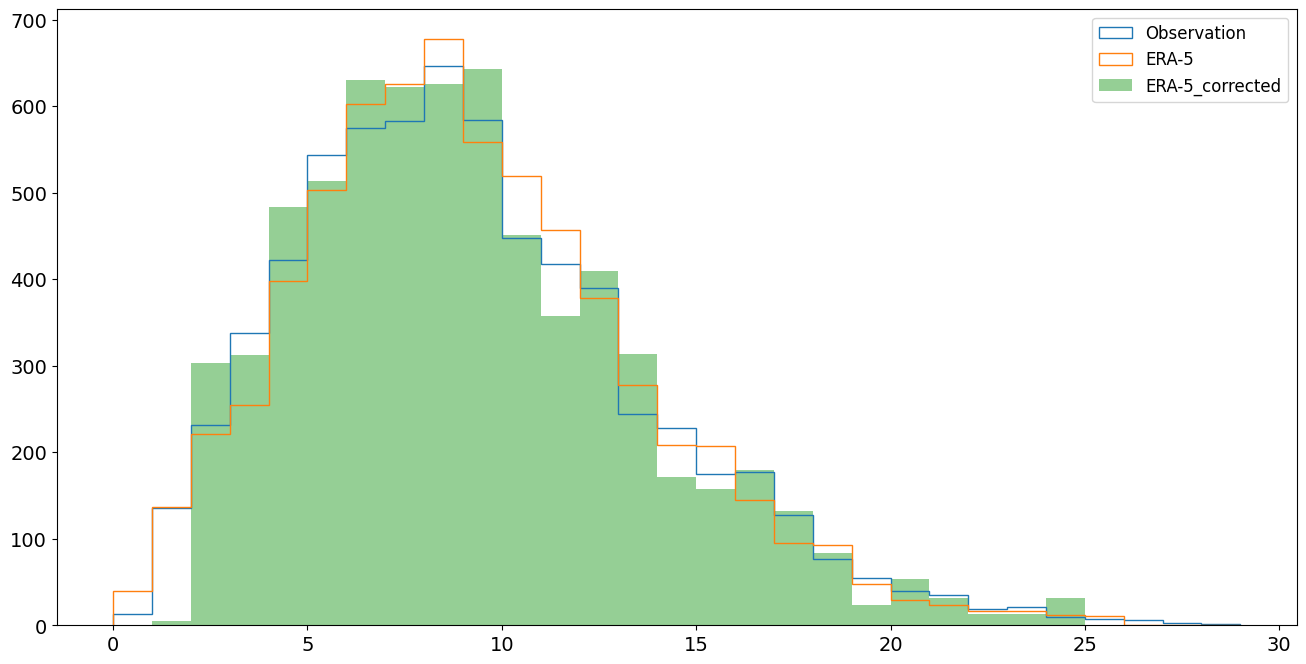

In [25]:
nbins = np.arange(0, 30, 1)

fig = plt.figure(figsize=(16,8))
plt.hist(data_mrgd['WS-99.2'].iloc[valid_values],nbins,label='Observation',histtype='step')
plt.hist(data_mrgd['WS100'].iloc[valid_values],nbins,label='ERA-5',histtype='step')
plt.hist(predictions[valid_values],nbins,label='ERA-5_corrected',alpha=0.5)
plt.xticks(fontsize= 14)
plt.yticks(fontsize= 14)
plt.legend(fontsize= 12)